# SBND PosRecoCVN Data Reader

Comprehensive notebook to read CNN position reconstruction results from SBNDPDSProducer output.
Supports both **TTree** (simple analysis) and **PixelMapVars** (detailed analysis) formats.

## Output Format Overview
The SBNDPDSProducer creates **two complementary data structures**:
1. **`inference_tree`**: Simple TTree with flat variables (recommended for quick analysis)
2. **`PixelMapVars`**: Complex object with PE images, matrices, and detailed physics data

In [58]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# File path - update this to your pixelmap_variables.root location
file_path = "/exp/sbnd/app/users/svidales/larsoft_develop/run_try/eleventh_attempt/ttree_analysis.root"  # Updated for complete data

print(f"Reading file: {file_path}")
print(f"File exists: {Path(file_path).exists()}")
if Path(file_path).exists():
    print(f"File size: {Path(file_path).stat().st_size / 1024:.1f} KB")
else:
    print("❌ File not found! Make sure you've run the job with both TFileService and RootOutput enabled.")

## Only TFileService output (ttree_analysis.root)

Simple, fast analysis using the flat TTree structure. Each row = one event.

In [63]:
# Open file and check for TTree
file = uproot.open(file_path)
print("ROOT file contents:")
for key in file.keys():
    print(f"  - {key}")

# Check subdirectories for TTree (often stored in TFileService subdirectories)
print("\nExploring subdirectories for TTrees:")
subdirs_to_check = []
for key in file.keys():
    try:
        obj = file[key]
        if hasattr(obj, 'keys'):  # It's a directory
            subdirs_to_check.append(key)
            print(f"\n📁 {key} contents:")
            subkeys = obj.keys()
            for subkey in subkeys:
                print(f"    - {subkey}")
                if 'tree' in subkey.lower() or 'inference' in subkey.lower():
                    print(f"      🌲 Found potential tree: {subkey}")
    except:
        continue

# Check if new TTree format exists (check both root level and subdirectories)
has_inference_tree = 'inference_tree' in file.keys()
inference_tree_path = None

if not has_inference_tree:
    # Check in subdirectories
    for subdir in subdirs_to_check:
        try:
            subdir_obj = file[subdir]
            if hasattr(subdir_obj, 'keys'):
                subkeys = subdir_obj.keys()
                for subkey in subkeys:
                    if 'inference_tree' in subkey.lower():
                        has_inference_tree = True
                        inference_tree_path = f"{subdir}/{subkey}"
                        print(f"\n✅ Found TTree at: {inference_tree_path}")
                        break
                if has_inference_tree:
                    break
        except:
            continue

print(f"\nNew TTree format available: {has_inference_tree}")
if inference_tree_path:
    print(f"TTree location: {inference_tree_path}")

# Also check for art framework data products (Events tree)
print(f"\nChecking for art framework data products...")
has_events = 'Events' in file.keys() or any('events' in key.lower() for key in file.keys())
print(f"Events tree available: {has_events}")

# Check if the PixelMapVars product exists in the file
has_pixelmap_vars = False
for key in file.keys():
    if 'PixelMapVars' in key or 'opanatree' in key:
        has_pixelmap_vars = True
        print(f"Found PixelMapVars-related key: {key}")

print(f"PixelMapVars data available: {has_pixelmap_vars}")

ROOT file contents:
  - opanatree;1
  - opanatree/inference_tree;1
  - MicroBoo znoise;1
  - MicroBoo unoise;1
  - MicroBoo vnoise;1
  - MicroBoo NoiseChan;1
  - Gaussian znoise;1
  - Gaussian unoise;1
  - Gaussian vnoise;1
  - Gaussian NoiseChan;1
  - Cohnoise;1
  - CohNoiseChan;1

Exploring subdirectories for TTrees:

📁 opanatree;1 contents:
    - inference_tree;1
      🌲 Found potential tree: inference_tree;1

📁 opanatree/inference_tree;1 contents:
    - run
    - subrun
    - event
    - passed_filters
    - true_x
    - true_y
    - true_z
    - pred_x
    - pred_y
    - pred_z
    - diff_x
    - diff_y
    - diff_z
    - error_3d
    - nuv_t
    - nuv_z
    - deposited_energy

✅ Found TTree at: opanatree;1/inference_tree;1

New TTree format available: True
TTree location: opanatree;1/inference_tree;1

Checking for art framework data products...
Events tree available: False
Found PixelMapVars-related key: opanatree;1
Found PixelMapVars-related key: opanatree/inference_tree;1
Pixel

In [66]:
if has_inference_tree:
    
    # Read all branches into arrays
    data = tree.arrays(library='pd')  # Read as pandas DataFrame
    
    # Filter events that passed filters
    passed_events = data[data['passed_filters'] == True]
    print(f"\n=== Filter Summary ====")
    print(f"Total events: {len(data)}")
    print(f"Passed filters: {len(passed_events)}")
    print(f"Success rate: {100*len(passed_events)/len(data):.1f}%")
    
    # Show events table - only passed events, and all events if <50
    if len(passed_events) < 50:
        print(f"\n=== All Events That Passed Filters ({len(passed_events)} events) ====")
        display(passed_events.round(2))
    else:
        print(f"\n=== First 10 Events That Passed Filters ====")
        display(passed_events.head(10).round(2))
    
    if len(passed_events) > 0:
        print(f"\n=== Performance Summary ({len(passed_events)} events) ====")
        
        # Calculate performance metrics for events that have predictions
        valid_predictions = passed_events[passed_events['error_3d'] != -999.0]
        
        if len(valid_predictions) > 0:
            coords = ['x', 'y', 'z']
            for coord in coords:
                diff_col = f'diff_{coord}'
                if diff_col in valid_predictions.columns:
                    diff_values = valid_predictions[diff_col].values
                    print(f"* {coord.upper()} coordinate:")
                    print(f"  - Mean difference (Bias): {np.mean(diff_values):6.2f} cm")
                    print(f"  - Std difference:         {np.std(diff_values):6.2f} cm")
                    print(f"  - RMSE:                   {np.sqrt(np.mean(diff_values**2)):6.2f} cm")
                    print(f"  - MAE:                    {np.mean(np.abs(diff_values)):6.2f} cm")
            
        else:
            print("No events with valid predictions found.")
    
else:
    print("❌ TTree format not found. File may be from older version without TTree support.")
    print("Checking if this might be due to old fcl outputCommands...")
    print("Make sure fcl file includes: 'keep *_TFileService_*_*'")


=== Filter Summary ====
Total events: 22
Passed filters: 12
Success rate: 54.5%

=== All Events That Passed Filters (12 events) ====


,run,subrun,event,passed_filters,true_x,true_y,true_z,pred_x,pred_y,pred_z,diff_x,diff_y,diff_z,error_3d,nuv_t,nuv_z,deposited_energy
1,358,91,11,True,146.0,171.6,48.1,143.3,178.2,63.2,-2.7,6.6,15.1,16.7,1276.2,24.8,328.0
5,358,91,31,True,115.7,168.2,438.5,122.7,179.3,448.8,7.0,11.1,10.3,16.7,1006.6,425.9,316.2
6,358,91,33,True,138.3,-55.6,76.1,146.9,-54.0,73.9,8.6,1.6,-2.2,9.1,1392.2,54.4,418.8
8,358,91,43,True,8.0,-187.9,499.5,34.0,-188.9,487.1,26.0,-0.9,-12.5,28.8,422.9,487.0,88.6
9,358,91,46,True,194.6,-198.0,312.4,189.6,-190.4,324.1,-5.0,7.6,11.7,14.8,1233.9,310.2,106.0
10,358,91,48,True,193.7,-181.5,373.4,194.5,-191.3,382.3,0.8,-9.8,8.9,13.3,455.5,380.7,154.5
11,358,91,50,True,95.0,-179.7,147.7,86.0,-181.5,158.1,-9.0,-1.8,10.4,13.9,1395.7,139.6,99.9
14,358,91,67,True,163.1,-90.5,123.4,159.4,-82.2,112.7,-3.7,8.2,-10.6,14.0,860.0,-22.0,575.8
15,358,91,69,True,147.9,78.6,210.3,142.5,72.5,225.5,-5.4,-6.1,15.2,17.2,502.5,179.5,630.2
17,358,91,82,True,108.3,-33.7,28.3,108.2,-30.8,35.1,-0.1,2.9,6.8,7.4,654.0,25.5,415.6



=== Performance Summary (12 events) ====
* X coordinate:
  - Mean difference (Bias):   2.55 cm
  - Std difference:           9.96 cm
  - RMSE:                    10.28 cm
  - MAE:                      7.42 cm
* Y coordinate:
  - Mean difference (Bias):   0.34 cm
  - Std difference:           6.95 cm
  - RMSE:                     6.96 cm
  - MAE:                      6.00 cm
* Z coordinate:
  - Mean difference (Bias):   2.24 cm
  - Std difference:          11.52 cm
  - RMSE:                    11.73 cm
  - MAE:                     10.84 cm


### TTree Visualization

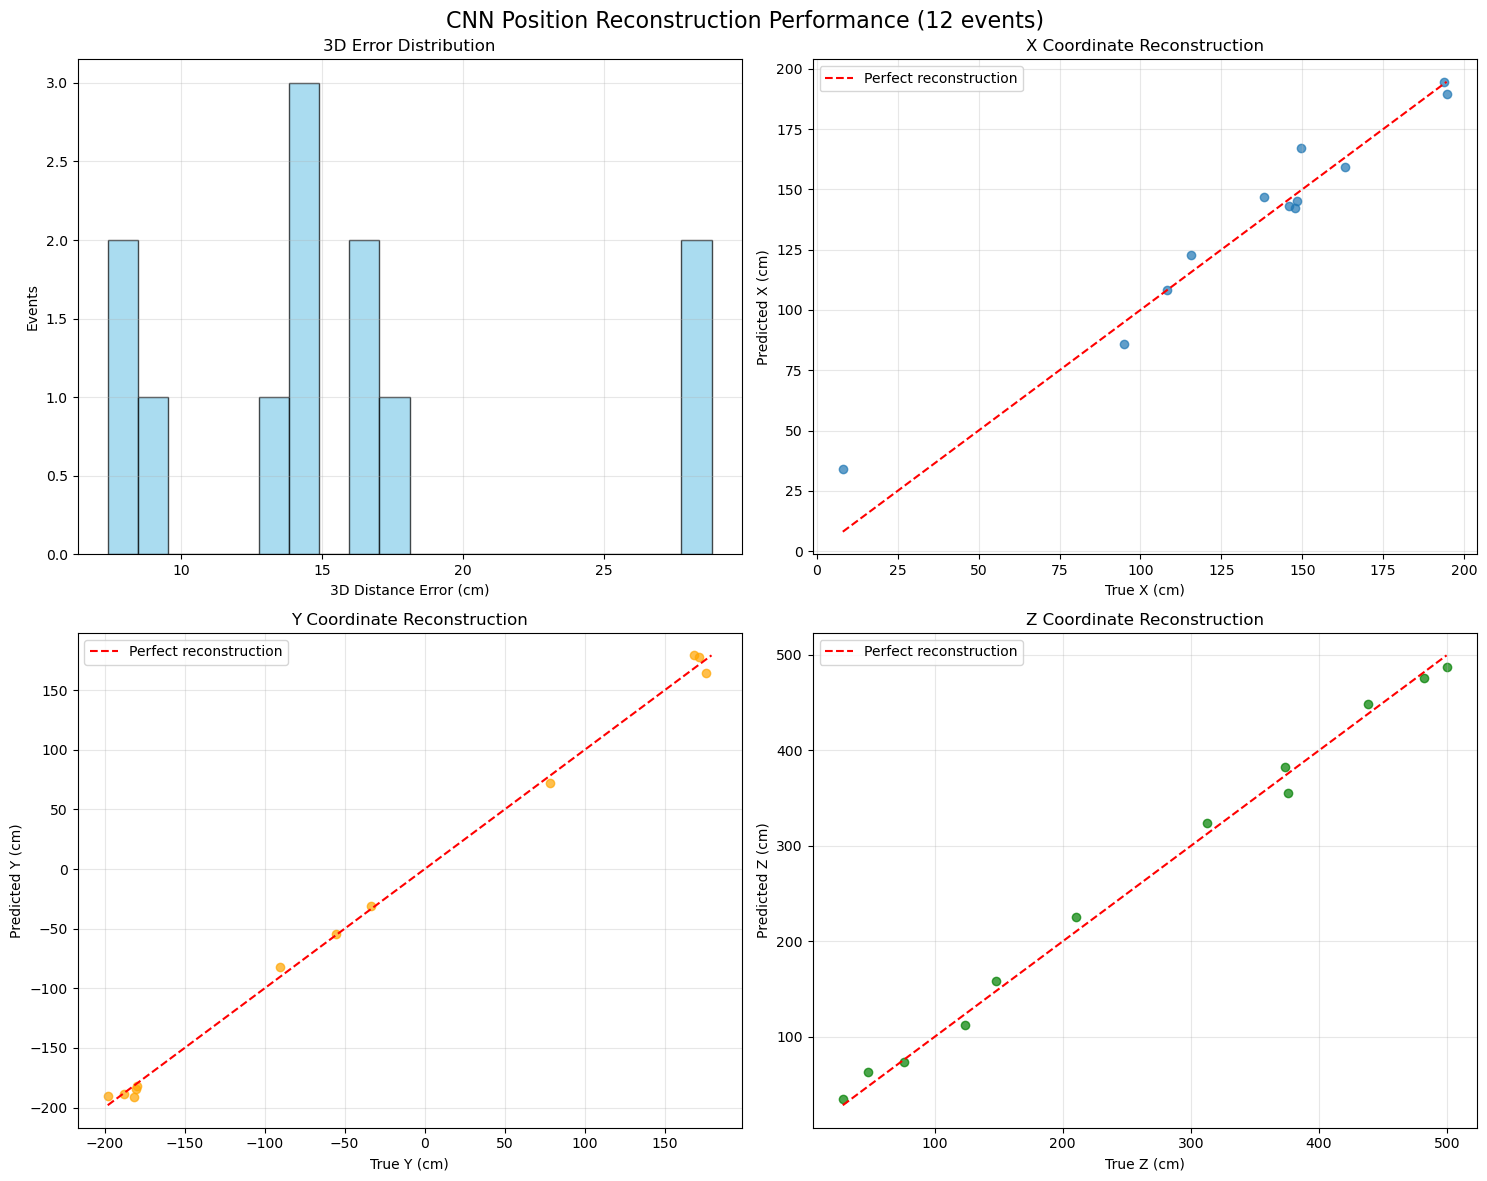

In [62]:
if has_inference_tree and len(passed_events) > 0:
    valid_predictions = passed_events[passed_events['error_3d'] != -999.0]
    
    if len(valid_predictions) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'CNN Position Reconstruction Performance ({len(valid_predictions)} events)', fontsize=16)
        
        # 3D error distribution
        axes[0,0].hist(valid_predictions['error_3d'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,0].set_xlabel('3D Distance Error (cm)')
        axes[0,0].set_ylabel('Events')
        axes[0,0].set_title('3D Error Distribution')
        axes[0,0].grid(True, alpha=0.3)
        
        # X coordinate comparison
        axes[0,1].scatter(valid_predictions['true_x'], valid_predictions['pred_x'], alpha=0.7)
        min_x, max_x = min(valid_predictions['true_x'].min(), valid_predictions['pred_x'].min()), max(valid_predictions['true_x'].max(), valid_predictions['pred_x'].max())
        axes[0,1].plot([min_x, max_x], [min_x, max_x], 'r--', label='Perfect reconstruction')
        axes[0,1].set_xlabel('True X (cm)')
        axes[0,1].set_ylabel('Predicted X (cm)')
        axes[0,1].set_title('X Coordinate Reconstruction')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Y coordinate comparison
        axes[1,0].scatter(valid_predictions['true_y'], valid_predictions['pred_y'], alpha=0.7, color='orange')
        min_y, max_y = min(valid_predictions['true_y'].min(), valid_predictions['pred_y'].min()), max(valid_predictions['true_y'].max(), valid_predictions['pred_y'].max())
        axes[1,0].plot([min_y, max_y], [min_y, max_y], 'r--', label='Perfect reconstruction')
        axes[1,0].set_xlabel('True Y (cm)')
        axes[1,0].set_ylabel('Predicted Y (cm)')
        axes[1,0].set_title('Y Coordinate Reconstruction')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Z coordinate comparison
        axes[1,1].scatter(valid_predictions['true_z'], valid_predictions['pred_z'], alpha=0.7, color='green')
        min_z, max_z = min(valid_predictions['true_z'].min(), valid_predictions['pred_z'].min()), max(valid_predictions['true_z'].max(), valid_predictions['pred_z'].max())
        axes[1,1].plot([min_z, max_z], [min_z, max_z], 'r--', label='Perfect reconstruction')
        axes[1,1].set_xlabel('True Z (cm)')
        axes[1,1].set_ylabel('Predicted Z (cm)')
        axes[1,1].set_title('Z Coordinate Reconstruction')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()